In [1]:
# import modules and libraries
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# reaction constants
c1 = 0.0022
print("c1: ", c1) 

# initial molecular population numbers of S1 and S2
X1 = 5.51
X2 = 85.4
print ("X1: ", X1)
print ("X2: ", X2)

# initialise time variable t and reaction counter n
t = 0
n = 0
print ("t: ", t)
print ("n: ", n)

c1:  0.0022
X1:  5.51
X2:  85.4
t:  0
n:  0


In [16]:
# calculate a1 = h1*c1 where h1 is the total number of all possible 
# combinations of pairs S1 and S2
a1 = X1*X2*c1
a = np.array([a1])
a0 = sum(a)

# debug
print ("a1: ", a1)
print ("a: ", a)
print ("a0: ", a0)

a1:  1.0352188000000002
a:  [1.0352188]
a0:  1.0352188000000002


In [17]:
# generate random numbers r1 and r2 from the normal distribution, using np.random.random
r = np.random.random(2)
r1 = r[0]
r2 = r[1]
print ("r1: ", r1)
print ("r2: ", r2)

# find the increment T in time as (1/a0)*ln(1/r1)
T = (1/a0)*np.log(1/r1)
print ("T: ", T)

# choose next reaction
mu = 0
N = r2*a0 - a[mu]

while N > 0:
    mu = mu + 1
    N = N - a[mu]

next_r = mu
print ("next_r: ", next_r)


r1:  0.5546081528058816
r2:  0.06924853522976226
T:  0.5694385047618384
next_r:  0


In [18]:
# define the time of next reaction
t = t + T
print ("t: ", t)

# add one to the number of reactions count n
n = n + 1
print ("n: ", n)

# update the system according to the reaction that was chosen
X1 = X1 + 1
X2 = X2 - 1
print ("X1: ", X1)
print ("X2: ", X2)

t:  0.5694385047618384
n:  1
X1:  6.51
X2:  84.4


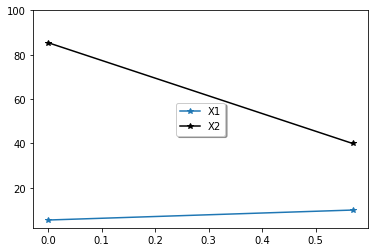

In [27]:
# create arrays containing all data
X1_all = np.array([5.51, 10]) # initial number and number after one reaction
X2_all = np.array([85.4, 40]) # initial number and number after one reaction
t_all = np.array([0, t]) # initial time and time of one reaction

# create plot
fig, ax = plt.subplots()
plt.ylim((2,100))
ax.plot(t_all, X1_all, '-*', label='X1')
ax.plot(t_all, X2_all, 'k-*', label='X2')
legend = ax.legend(loc='center', shadow=True)
plt.show()

In [1]:
import multiprocessing
import tqdm

import numpy as np
import scipy.stats as st
import numba

import biocircuits

# Plotting modules
import matplotlib.pyplot as plt
import bokeh.io
import bokeh.plotting

In [2]:
def muestraDiscreta(prob):
    #Al azar da un index con probabilidad prob
    #Numero al azar
    n = np.random.rand()
    #Dar indice
    i = 0
    pSum = 0.0
    while pSum < n:
        pSum = pSum + prob[i]
        i = i+1
    return i-1

prob1 = np.array([0.1,0.3,0.4,0.05,0.15,1])

In [3]:
def gillespieChoice(propensitiesFunction,propensities,population,time,args = ()):
    """Nos da la reaccion seleccionada al azar y el tiempo que se demoro en
    hacer la reaccion.
    """
    #Calcular propensities. 
    propensitiesFunction(propensities,population,time,*args)
    
    #Suma de las propensities.
    propsSum = propensities.sum()

    
    
    #Dar nuevo tiempo exponencial.
    t = np.random.exponential(1.0/propsSum)
    
    #Probabilidad discreta de cada reaccion:
    rDProb = propensities/propsSum
    
    #Sacar una reaccion de la distribucion
    reaction = muestraDiscreta(rDProb)
    
    return reaction, t

In [4]:
"""
Tenemos la funcion que escoge nuestra reaccion. Ahora escribimos nuestro 
algoritmo de simulacion estocastico  (ASE)
"""

def gillespieSim1(propensityFunction, 
                  update,population0, 
                  timePoints, 
                  args =()):
    
    #Inicializar el output.
    outSol = np.empty((len(timePoints),update.shape[1]), dtype = int)
    
    #Inicializar y realizar la simulacion.
    timei = 1
    i = 0
    t = timePoints[0]
    population = population0.copy()
    outSol[0,:] = population
    propensities = np.zeros(update.shape[0])
    
    while i < len(timePoints):
        while t < timePoints[timei]:
            #Sacar evento y tiempo que paso para el evento.
            evento, dt = gillespieChoice(propensityFunction, propensities, population, t, args)
            
            #Actualizar la poblacion y el tiempo
            poblacionAnterior = population.copy()
            population += update[evento,:]
            
            t = t + dt
        #Actualizar indice
        i = np.searchsorted(timePoints >t,True)
        outSol[timei: min(i,len(timePoints))] = poblacionAnterior
        timei = i
    return outSol

In [5]:
simple_update = np.array(
    [
        [1, 0],  # Make mRNA transcript
        [-1, 0],  # Degrade mRNA
        [0, 1],  # Make protein
        [0, -1],  # Degrade protein
    ],
    dtype=int,
)

def simple_propensity(propensities, population, t, beta_m, beta_p, gamma):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population

    # Update propensities
    propensities[0] = beta_m  # Make mRNA transcript
    propensities[1] = m  # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p  # Degrade protein

In [6]:
# Specify parameters for calculation
args = (10.0, 10.0, 0.4)
time_points = np.linspace(0, 50, 101)
population_0 = np.array([0, 0], dtype=int)
size = 500

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((size, len(time_points), 2), dtype=int)

# Run the calculations
for i in tqdm.tqdm(range(size)):
    samples[i, :, :] = gillespieSim1(
        simple_propensity, simple_update, population_0, time_points, args=args
    )  

100%|██████████| 500/500 [05:11<00:00,  1.60it/s]


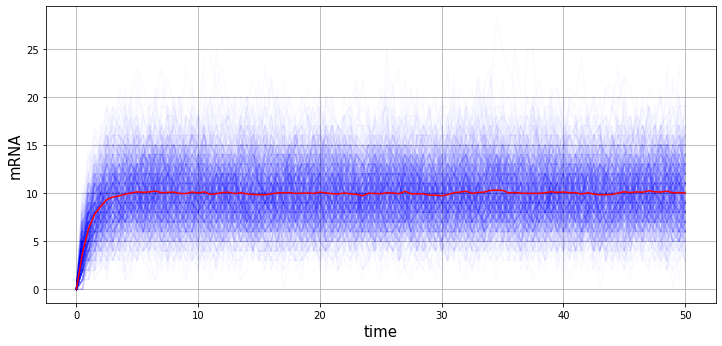

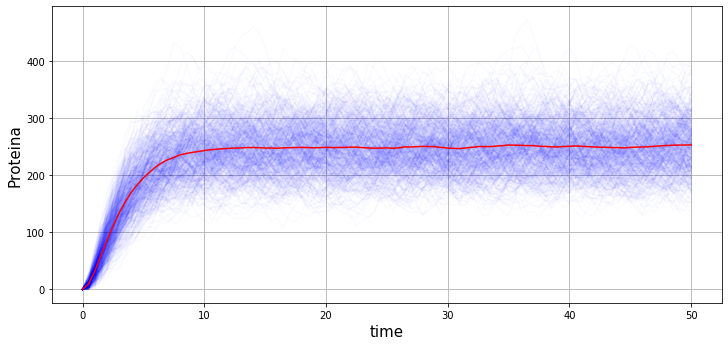

In [7]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time",fontsize=15)
plt.ylabel("mRNA",fontsize=15)
plt.grid()
for i in range(size):
    plt.plot(time_points,samples[i,:,0],alpha=0.02, color ="blue")
plt.plot(time_points,samples[:, :, 0].mean(axis=0),color ="red")



plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time",fontsize=15)
plt.ylabel("Proteina",fontsize=15)
plt.grid()
for i in range(size):
    plt.plot(time_points,samples[i,:,1],alpha=0.02,color = "blue")
plt.plot(time_points,samples[:, :, 1].mean(axis=0),color ="red")